In [1]:
import pbjam as pb
import pandas as pd
import lightkurve as lk
from tqdm import tqdm

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_lc(target):
    lc_all = lk.search_lightcurvefile(target).download_all()
    lc = lc_all[0].PDCSAP_FLUX.normalize().remove_outliers().flatten()
    for lcx in lc_all[1:]:
        lc = lc.append(lcx.PDCSAP_FLUX.normalize().remove_outliers().flatten())
    lc = lc.remove_outliers(4)
    return lc

def to_pg(lc, numax, dnu):
    pg = lc.to_periodogram(normalization='psd', 
                           minimum_frequency=numax - 3.0*dnu,
                           maximum_frequency=numax + 3.0*dnu).flatten()
    return pg

In [3]:
df = pd.read_csv('mytgts.csv')
df.head()

,ID,dnu,dnu_err,numax,numax_err,teff,teff_err,bp_rp,bp_rp_err
0,1433593,6.241,0.013,69.14,0.59,4956,100,1.327025,0.05
1,1433730,4.085,0.019,40.37,0.54,4767,100,1.424954,0.05
2,2018392,3.795,0.013,33.92,0.55,4908,100,1.417112,0.05
3,2140446,5.673,0.012,57.60,0.56,4665,100,1.446697,0.05
4,2307683,4.309,0.012,39.95,0.51,4799,100,1.369279,0.05


In [4]:
lcs = {}
for idx, row in df.iterrows():
    print('.', end='')
    ID = str(int(row.ID))
    lcs[ID] = get_lc(ID)

.........

In [5]:
pgs = {}
for idx, row in df.iterrows():
    ID = str(int(row.ID))
    pgs[ID] = to_pg(lcs[ID], row.numax, row.dnu)

In [6]:
stars = {}
for idx, row in df.iterrows():
    ID = str(int(row.ID))
    star = pb.jar.star(ID, pgs[ID].frequency.value, pgs[ID].power.value, 
                       [row.numax, row.numax_err], 
                       [row.dnu, row.dnu_err], 
                       [row.teff, row.teff_err],
                       [row.bp_rp, row.bp_rp_err], 
                       store_chains=True, 
                       nthreads=4)
    stars[ID] = star

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:18<00:00, 424.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:18<00:00, 439.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:17<00:00, 449.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:20<00:00, 392.40draws/s]
Auto-assigning NUTS sampler...
I

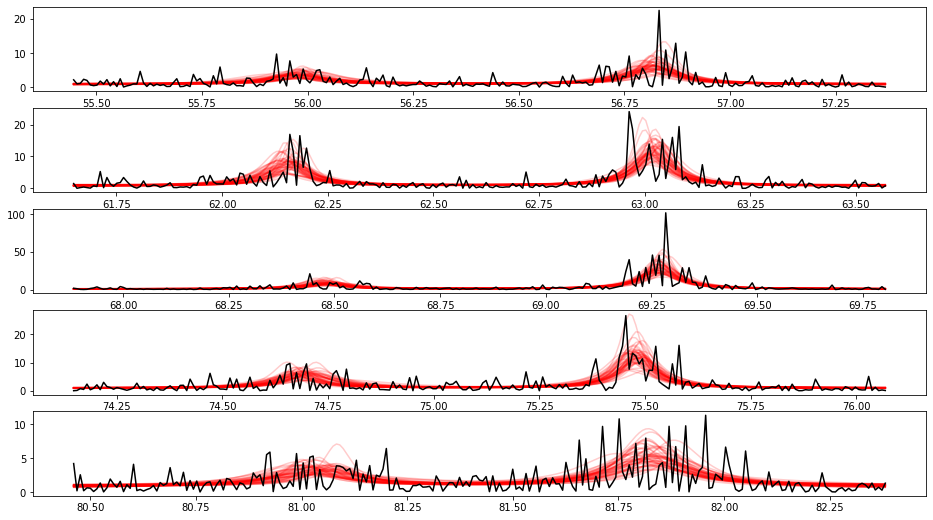

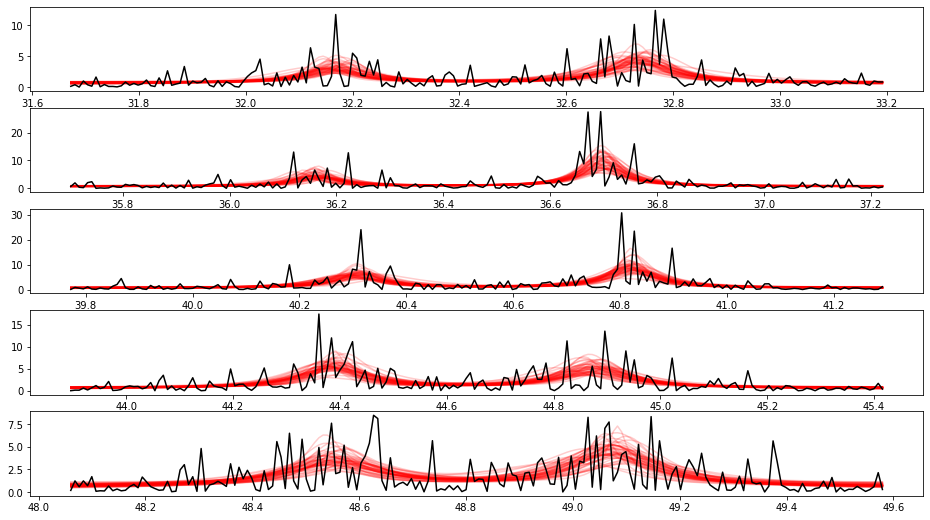

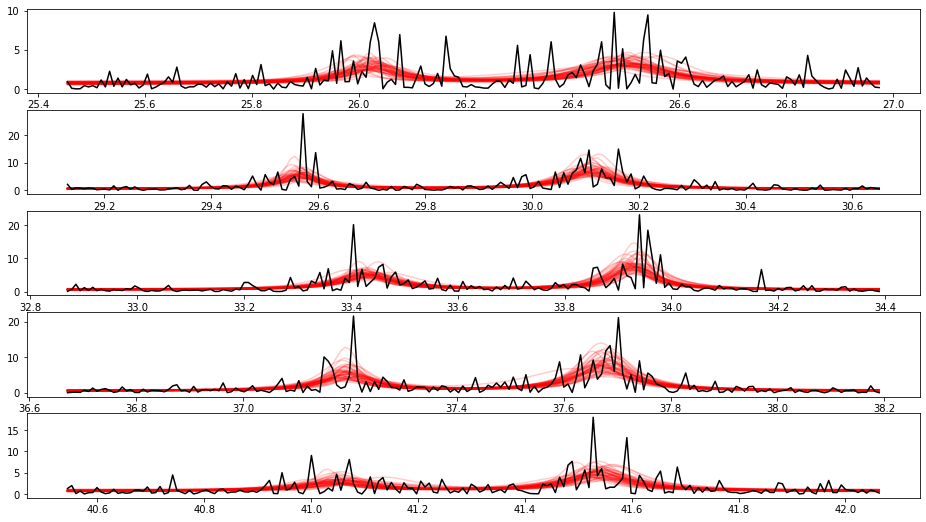

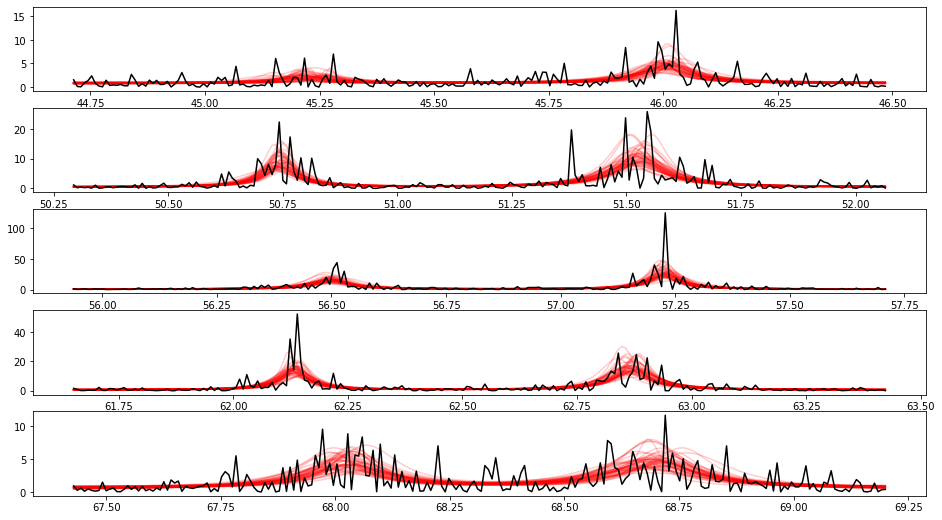

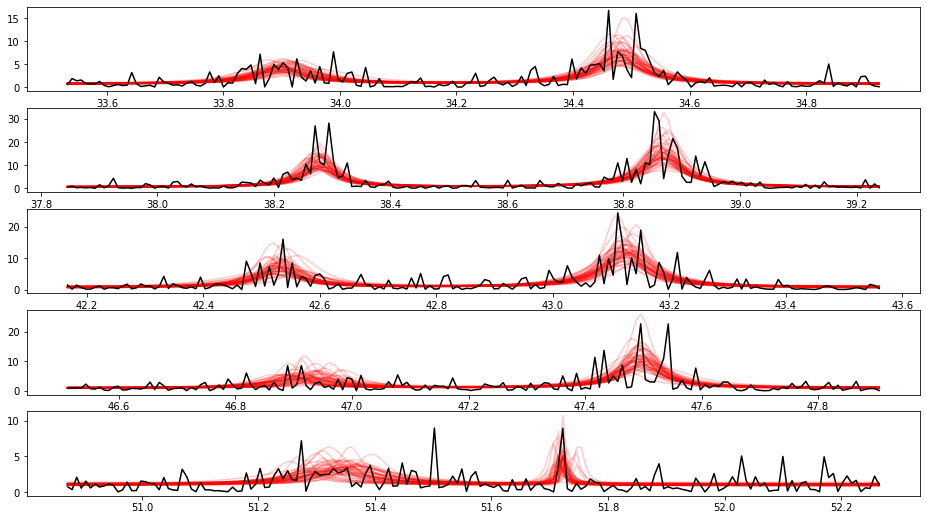

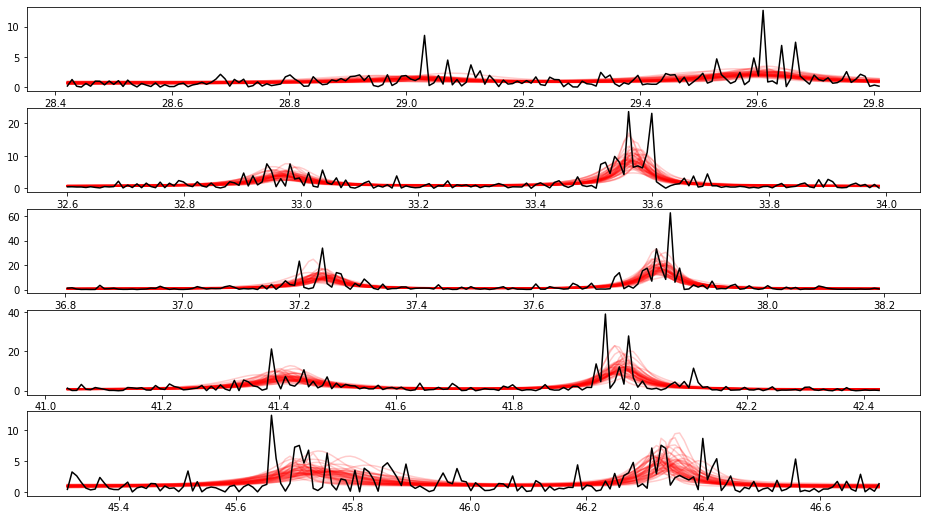

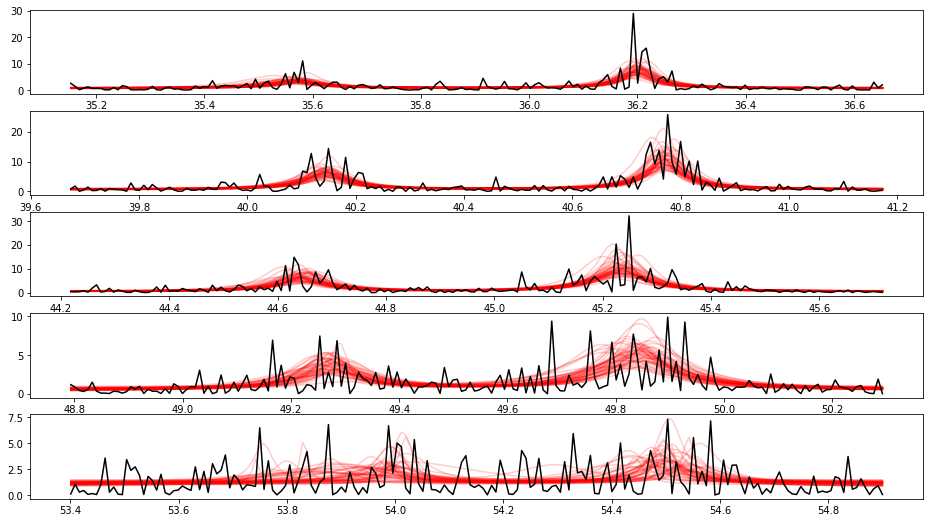

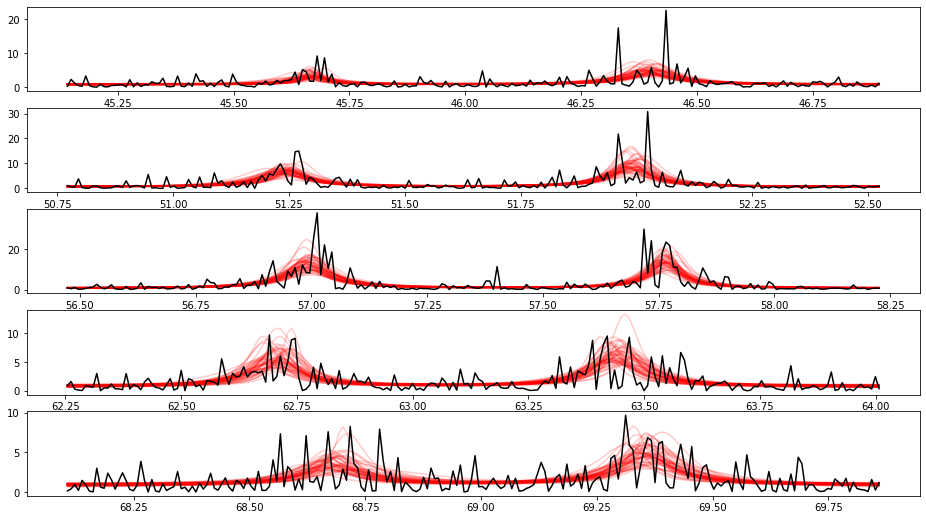

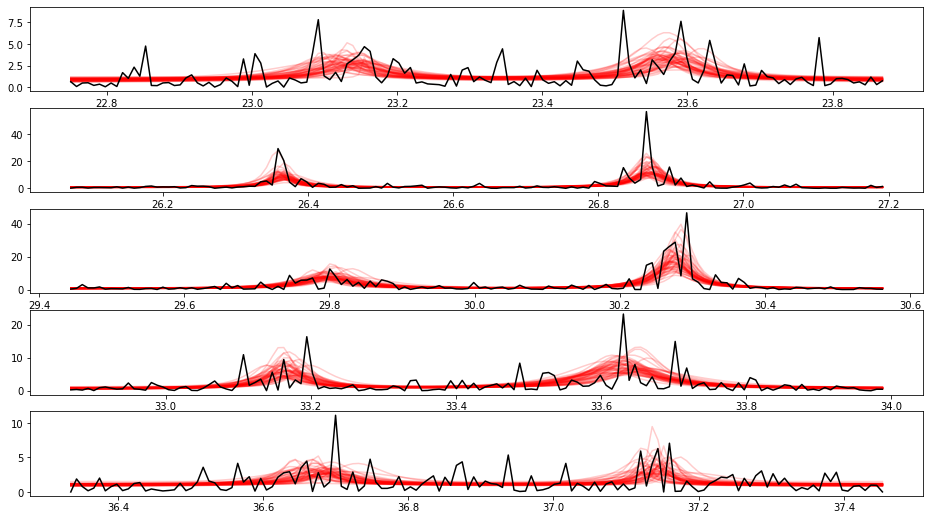

In [7]:
for idx, row in df.iterrows():
    ID = str(int(row.ID))
    stars[ID].run_epsilon()
    stars[ID].run_asy_peakbag(norders=5, burnin=5000)
    stars[ID].run_peakbag()
    stars[ID].peakbag.plot_fit(thin=10)